In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
warnings.filterwarnings("ignore")

# Open CSVs with data

In [ ]:
df = pd.read_csv(r'/data_traffic/expressways_work_mar.csv')

In [ ]:
df_d = pd.read_csv(r'/data_traffic/expressways_work.csv')

In [5]:
df.head()

,Unnamed: 0,Date,Time,LinkID,RoadCategory,SpeedBand,Quantile_Road,Type,I,Region,Work
0,0,20210301,00:30,103000078,A,8,7,No Incident,0.0,west,0
1,1,20210314,20:50,103000078,A,8,7,No Incident,0.0,west,0
2,2,20210302,04:35,103000078,A,8,7,No Incident,0.0,west,0
3,3,20210303,18:45,103000078,A,8,7,No Incident,0.0,west,0
4,4,20210309,00:25,103000078,A,8,7,No Incident,0.0,west,0


# Pre-processing steps

In [6]:
df['Time'] = np.where(df['Time'] == '0:', '00:00', df['Time'])
df['Time'] = np.where(df['Time'] == '5:', '00:05', df['Time'])

In [7]:
df_d['Time'] = np.where(df_d['Time'] == '0:', '00:00', df_d['Time'])
df_d['Time'] = np.where(df_d['Time'] == '5:', '00:05', df_d['Time'])

In [8]:
df['I'] = np.where(df['Type'] == 'Roadwork', 0, df['I'])

In [9]:
df_d['I'] = np.where(df_d['Type'] == 'Roadwork', 0, df_d['I'])

In [10]:
#df = df[['Date', 'Time', 'LinkID', 'SpeedBand', 'Quantile_Road', 'I', 'Region', 'Work']]

df['I_F'] = np.where((df['I'] == 1) & (df['Work'] == 0), 1, 0)
df['I_W'] = np.where((df['I'] == 1) & (df['Work'] == 1), 1, 0)

df['C'] = np.where((df['I'] == 0) & (df['SpeedBand'] < df['Quantile_Road']), 1, 0)

In [11]:
#df_d = df_d[['Date', 'Time', 'LinkID', 'SpeedBand', 'Quantile_Road', 'I', 'Region', 'Work']]

df_d['I_F'] = np.where((df_d['I'] == 1) & (df_d['Work'] == 0), 1, 0)
df_d['I_W'] = np.where((df_d['I'] == 1) & (df_d['Work'] == 1), 1, 0)

df_d['C'] = np.where((df_d['I'] == 0) & (df_d['SpeedBand'] < df_d['Quantile_Road']), 1, 0)

In [12]:
def minute_interval(start,end):
    start = datetime.strptime(start, '%H:%M').time()
    end = datetime.strptime(end, '%H:%M').time()
    start_sec= (start.hour*60+start.minute)*60+start.second
    end_sec= (end.hour*60+end.minute)*60+end.second
    return (end_sec-start_sec)/60.0

# Get all states values

In [13]:
def data_preparation(df_full, t0, t1):
    df = df_full[(df_full['Time'] >= t0) & (df_full['Time'] < t1)]
    roads = df.LinkID.unique()
    days = df.Date.unique()
    list_df = []

    for road in roads:
        df_road = df[df['LinkID'] == road].copy()
        days = df_road.Date.unique()
        df_road['Time_Congested_R'] = '99:99'
        df_road['First_Time_Congested_R'] = 0
        df_road['R'] = 0
        for day in days:
            df_road['Time_Congested_R'] = np.where((df_road['Date'] == day) & (df_road['C'] == 1), df_road['Time'], df_road['Time_Congested_R'])
            min_time_r = min(df_road[df_road['Date'] == day]['Time_Congested_R'])
            df_road['First_Time_Congested_R'] = np.where((df_road['Date'] == day), min_time_r, df_road['First_Time_Congested_R'])
            df_road['R'] = np.where((df_road['Date'] == day) & (df_road['C'] == 0) & (df_road['Time'] > df_road['First_Time_Congested_R']), 1, df_road['R'])
        
        list_df.append(df_road[['Date', 'Time', 'LinkID', 'C', 'R', 'I_F', 'I_W', 'Work']])
        
    df = pd.concat(list_df, ignore_index = True)
    df['F_F'] = np.where((df['C'] == 0) & (df['R'] == 0) & (df['I_F'] == 0) & (df['Work'] == 0), 1, 0)
    df['F_W'] = np.where((df['C'] == 0) & (df['R'] == 0) & (df['I_W'] == 0) & (df['Work'] == 1), 1, 0)
    df['I_F'] = np.where((df['I_F'] == 1) & (df['R'] == 1), 0 , df['I_F'])
    df['I_W'] = np.where((df['I_W'] == 1) & (df['R'] == 1), 0 , df['I_W'])
    
    df_summary = df.groupby(['Date', 'Time']).agg({'C' : 'sum',
                                               'F_F': 'sum',
                                               'F_W': 'sum',
                                               'I_F': 'sum',
                                               'I_W': 'sum',
                                               'R': 'sum',
                                               'LinkID': 'count'}).reset_index()
    
    df_summary['% C'] = df_summary['C']/df_summary['LinkID']
    df_summary['% F_F'] = df_summary['F_F']/df_summary['LinkID']
    df_summary['% F_W'] = df_summary['F_W']/df_summary['LinkID']
    df_summary['% I_F'] = df_summary['I_F']/df_summary['LinkID']
    df_summary['% I_W'] = df_summary['I_W']/df_summary['LinkID']
    df_summary['% R'] = df_summary['R']/df_summary['LinkID']

    df_plot = df_summary[['Date', 'Time', '% C', '% F_F', '% F_W', '% I_F', '% I_W', '% R']]
    
    df_plot['Date'] = df_plot['Date'].astype(str)
    df_plot['Date'] = df_plot['Date'].apply(lambda x: datetime.strptime(x, '%Y%m%d').strftime('%m/%d/%Y'))
    
    df_plot['Date'] = pd.to_datetime(df_plot['Date'])
    df_plot['Day_of_Week'] = df_plot['Date'].apply(lambda x: x.strftime('%A'))
    
    df_plot['Day_of_Week'] = df_plot['Date'].apply(lambda x: x.strftime('%A'))

    df_plot['Time'] = df_plot['Time'].apply(lambda x: datetime.strptime(x, '%H:%M').time().strftime('%H:%M:%S'))
    
    days = df_plot['Date'].unique()
    number_period = int(minute_interval(t0, t1)/5)
    days_to_keep = []
    for d in days:
        if df_plot[df_plot['Date'] == d]['Time'].nunique() == number_period:
            days_to_keep.append(d)
    
    df_plot = df_plot[df_plot['Date'].isin(days_to_keep)]
    df_plot = df_plot[~df_plot['Day_of_Week'].isin(['Saturday', 'Sunday'])]
    
    return df_plot   

In [14]:
def compute_dist(df):
    days = df['Date'].unique()
    dist = [[1 for t in range(len(days))] for t in range(len(days))]
    for i in range(len(days)):
        for j in range(len(days)):
            d_ij = sum((df[df['Date'] == days[i]].reset_index()['% C'] - df[df['Date'] == days[j]].reset_index()['% C'])**2)
            dist[i][j] = d_ij
    return dist, days

In [15]:
def remove_outliers(df):
    df = df[~df['Day_of_Week'].isin(['Satrurday', 'Sunday'])]
    dist, days = compute_dist(df)
    mean_dist = dict()
    means = []
    
    for i in range(len(days)):
        mean_i = 0
        for j in range(len(days)):
            if j != i:
                mean_i += dist[i][j]
            mean_i = mean_i/(len(days)-1)
        mean_dist[days[i]] = mean_i
        means.append(mean_i)
    
    outliers = []
    m = np.mean(means)
    for d in days:
        if mean_dist[d] > 1.5*m:
            outliers.append(d)
    
    df_return = df[~df['Date'].isin(outliers)]
    
    return df_return

# Define SIR Model

In [16]:
def sir_model_complex(y, x, alpha_S, beta_S, rho_S, mu_S, alpha_W, beta_W, rho_W, mu_W, theta):
    S = -alpha_S*y[0]*(y[1] + y[3] + y[4]) - beta_S*y[0] + rho_S*mu_S*y[1]
    AS = beta_S*y[0] - mu_S*y[1]
    W = -alpha_W*y[2]*(y[1] + y[3] + y[4]) - beta_W*y[2] + rho_W*mu_W*y[3]
    AW = beta_W*y[2] - mu_W*y[3]
    R = theta*y[4]
    I = - (S + W + AS + AW + R)
    return S, AS, W, AW, I, R

def fit_odeint_complex(x, alpha_S, beta_S, rho_S, mu_S, alpha_W, beta_W, rho_W, mu_W, theta):
    return integrate.odeint(sir_model_complex, (S0, AS0, W0, AW0, I0, R0), x, args=(alpha_S, beta_S, rho_S, mu_S, alpha_W, beta_W, rho_W, mu_W, theta))[:,1]


# MAPE Score

In [17]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Train the model based on past data

In [18]:
def train_model(df, t0, t1, plot = False):
    
    df_prep = data_preparation(df, t0, t1)
    df_predict = remove_outliers(df_prep)
    
    days = df_predict['Date'].unique()
    
    i = 1
    xdata = []
    ydata = []
    for t in df_predict['Time'].unique():
        for d in df_predict['Date'].unique():
            try:
                y = list(df_predict[(df_predict['Date'] == d) & (df_predict['Time'] == t)]['% C'])[0]
                xdata.append(i)
                ydata.append(y)
            except:
                print(d)
                print(t)
        i += 1
    
    def sir_model_complex(y, x, alpha_S, beta_S, rho_S, mu_S, alpha_W, beta_W, rho_W, mu_W, theta):
        S = -alpha_S*y[0]*(y[1] + y[3] + y[4]) - beta_S*y[0] + rho_S*mu_S*y[1]
        AS = beta_S*y[0] - mu_S*y[1]
        W = -alpha_W*y[2]*(y[1] + y[3] + y[4]) - beta_W*y[2] + rho_W*mu_W*y[3]
        AW = beta_W*y[2] - mu_W*y[3]
        R = theta*y[4]
        I = - (S + W + AS + AW + R)
        return S, AS, W, AW, I, R

    def fit_odeint_complex(x, alpha_S, beta_S, rho_S, mu_S, alpha_W, beta_W, rho_W, mu_W, theta):
        return integrate.odeint(sir_model_complex, (S0, AS0, W0, AW0, I0, R0), x, args=(alpha_S, beta_S, rho_S, mu_S, alpha_W, beta_W, rho_W, mu_W, theta))[:,1]


    
    N = 1.0
    I0 = ydata[0]
    S0 = df_predict[df_predict['Date'] == df_predict['Date'][0]].reset_index()['% F_F'][0]
    AS0 = df_predict[df_predict['Date'] == df_predict['Date'][0]].reset_index()['% I_F'][0]
    W0 = df_predict[df_predict['Date'] == df_predict['Date'][0]].reset_index()['% F_W'][0]
    AW0 = df_predict[df_predict['Date'] == df_predict['Date'][0]].reset_index()['% I_W'][0]
    R0 = 1 - I0 - S0 - AS0 - W0 - AW0
    
    #bounds_param = [np.inf, np.inf, 1, np.inf, np.inf, np.inf, 1, np.inf, np.inf]
    #popt, pcov = optimize.curve_fit(fit_odeint_complex, xdata, ydata, bounds = (0, bounds_param))
    popt, pcov = optimize.curve_fit(fit_odeint_complex, xdata, ydata, bounds = (0, np.inf))
    
    fitted = fit_odeint_complex(xdata, *popt)
    
    rmse = np.sqrt(mean_squared_error(ydata, fitted))
    mape_ = mape(ydata, fitted)
    mae = mean_absolute_error(ydata, fitted)
    
    
    xdata_time = df_predict['Time'].unique()
    xdata_plot = [str(i)[:5] for i in xdata_time]
    y_full = []
    days = df_predict['Date'].unique()
    for d in days:
        y_day = df_predict[df_predict['Date'] == d]['% C']
        ydata = np.array(y_day, dtype=float)
        y_full.append(ydata)
    
    if plot:
        
        plt3 = plt.figure(figsize = (8,6))
        plt.plot(xdata_plot, fitted[::len(days)], label = "Fitted", color = 'c')
        
        for d in range(len(days)):
            plt.plot(xdata_plot, y_full[d], 'o', label = np.datetime_as_string(days[d])[:10])

        plt.title('March Week Days, Evolution of Congestion')
        plt.xlabel('Time of Day')
        plt.xticks(xdata_plot[::12])
        plt.ylabel('% Congested Roads')
        plt.legend()
        plt.show()
    
    return fitted, y_full, xdata_plot, days, popt, rmse, mape_, mae

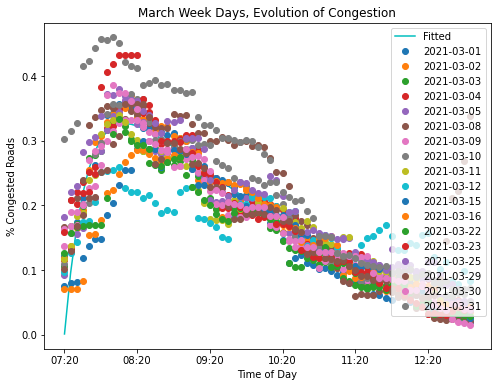

In [19]:
f, y, x, d, popt, mse, mape_, mae  = train_model(df, '07:20', '13:00', plot = True)

# Train + Test

In [20]:
def train_test_model(df, df_test, t0, t1, plot = False, initial = False):
    
    df_prep = data_preparation(df, t0, t1)
    df_predict = remove_outliers(df_prep)
    
    df_prep_test = data_preparation(df_test, t0, t1)
    df_prep_test = remove_outliers(df_prep_test)
    
    days = df_predict['Date'].unique()
    
    i = 1
    xdata = []
    ydata = []
    for t in df_predict['Time'].unique():
        for d in df_predict['Date'].unique():
            try:
                y = list(df_predict[(df_predict['Date'] == d) & (df_predict['Time'] == t)]['% C'])[0]
                xdata.append(i)
                ydata.append(y)
            except:
                print(d)
                print(t)
        i += 1
    
    def sir_model_complex(y, x, alpha_S, beta_S, rho_S, mu_S, alpha_W, beta_W, rho_W, mu_W, theta):
        S = -alpha_S*y[0]*(y[1] + y[3] + y[4]) - beta_S*y[0] + rho_S*mu_S*y[1]
        AS = beta_S*y[0] - mu_S*y[1]
        W = -alpha_W*y[2]*(y[1] + y[3] + y[4]) - beta_W*y[2] + rho_W*mu_W*y[3]
        AW = beta_W*y[2] - mu_W*y[3]
        R = theta*y[4]
        I = - (S + W + AS + AW + R)
        return S, AS, W, AW, I, R

    def fit_odeint_complex(x, alpha_S, beta_S, rho_S, mu_S, alpha_W, beta_W, rho_W, mu_W, theta):
        return integrate.odeint(sir_model_complex, (S0, AS0, W0, AW0, I0, R0), x, args=(alpha_S, beta_S, rho_S, mu_S, alpha_W, beta_W, rho_W, mu_W, theta))[:,1]


    
    N = 1.0
    I0 = ydata[0]
    S0 = df_predict[df_predict['Date'] == df_predict['Date'][0]].reset_index()['% F_F'][0]
    AS0 = df_predict[df_predict['Date'] == df_predict['Date'][0]].reset_index()['% I_F'][0]
    W0 = df_predict[df_predict['Date'] == df_predict['Date'][0]].reset_index()['% F_W'][0]
    AW0 = df_predict[df_predict['Date'] == df_predict['Date'][0]].reset_index()['% I_W'][0]
    R0 = 1 - I0 - S0 - AS0 - W0 - AW0
    
    if initial:
        print('S: ', S0)
        print('AS:', AS0)
        print('W:', W0)
        print('AW:', AW0)
        print('C:', I0)
        print('R:', R0)
    
    #bounds_param = [np.inf, np.inf, 1, np.inf, np.inf, np.inf, 1, np.inf, np.inf]
    #popt, pcov = optimize.curve_fit(fit_odeint_complex, xdata, ydata, bounds = (0, bounds_param))
    popt, pcov = optimize.curve_fit(fit_odeint_complex, xdata, ydata, bounds = (0, np.inf))
    fitted = fit_odeint_complex(xdata, *popt)
    
    xdata_time = df_predict['Time'].unique()
    xdata_plot = [str(i)[:5] for i in xdata_time]
    y_full = []
    days = df_predict['Date'].unique()
    
    mse_train = {}
    mape_train = {}
    mae_train = {}
    
    for d in days:
        y_day = df_predict[df_predict['Date'] == d]['% C']
        ydata = np.array(y_day, dtype=float)
        y_full.append(ydata)
        mse_train[str(d)[:10]] = np.sqrt(mean_squared_error(ydata, fitted[::len(days)]))
        mape_train[str(d)[:10]] = mape(ydata, fitted[::len(days)])
        mae_train[str(d)[:10]] = mean_absolute_error(ydata, fitted[::len(days)])
    
    if plot:
        
        plt3 = plt.figure(figsize = (8,6))
        plt.plot(xdata_plot, fitted[::len(days)], linewidth = 3, label = "Fitted", color = 'c')
        
        for d in range(len(days)):
            plt.plot(xdata_plot, y_full[d], 'o', markersize = 3)

        plt.title('March Week Days, Evolution of Congestion')
        plt.xlabel('Time of Day')
        plt.xticks(xdata_plot[::12])
        plt.ylabel('% Congested Roads')
        plt.legend()
        plt.show()
        
    days_test = df_prep_test['Date'].unique()
    test = 0
    mse = 0
    mape_ = 0
    mae = 0
    mse_test, mape_test, mae_test = {}, {}, {}
    for d in days_test:
        
        N = 1.0
        I0 = df_prep_test[df_prep_test['Date'] == d].reset_index()['% C'][0]
        S0 = df_prep_test[df_prep_test['Date'] == d].reset_index()['% F_F'][0]
        AS0 = df_prep_test[df_prep_test['Date'] == d].reset_index()['% I_F'][0]
        W0 = df_prep_test[df_prep_test['Date'] == d].reset_index()['% F_W'][0]
        AW0 = df_prep_test[df_prep_test['Date'] == d].reset_index()['% I_W'][0]
        R0 = 1 - I0 - S0 - AS0 - W0 - AW0
        
        ydata = df_prep_test[df_prep_test['Date'] == d]['% C']
        ydata = np.array(ydata, dtype=float)
        
        xdata_time = df_predict['Time'].unique()
        xdata_test = np.array([i+1 for i in range(len(xdata_time))])
        xdata_plot_t = [str(i)[:5] for i in xdata_time]
        fitted_t = fit_odeint_complex(xdata_test, *popt)
        
        try:
            mse_test[str(d)[:10]] = np.sqrt(mean_squared_error(ydata, fitted_t))
            mape_test[str(d)[:10]] = mape(ydata, fitted_t)
            mae_test[str(d)[:10]] = mean_absolute_error(ydata, fitted_t)
        except:
            print('Large')
        
        try:
            mse += mean_squared_error(ydata, fitted_t)/len(days_test)
            mape_ += mape(ydata, fitted_t)/len(days_test)
            mae += mean_absolute_error(ydata, fitted_t)/len(days_test)
        except:
            print('Large')
            
        if test < 1 and plot == True:
            plt.plot(xdata_plot_t, ydata, 'o', label = 'Data')
            plt.plot(xdata_plot_t, fitted_t, label = "Fitted")
            plt.title('Fitted Congestion, Day: {}'.format(str(d)[:10]))
            plt.xlabel('Time of Day')
            plt.xticks(xdata_plot_t[::12])
            plt.ylabel('% Congested Roads')
            plt.show()
        test += 1
    
    return fitted, y_full, xdata_plot, days, days_test, popt, mse, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test


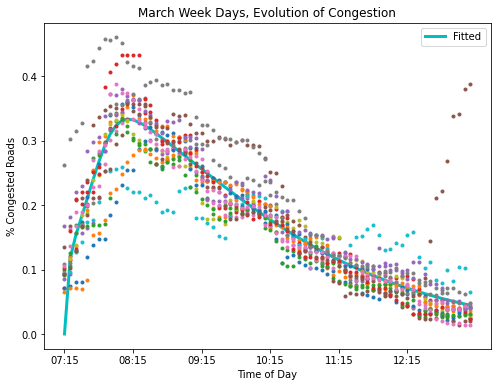

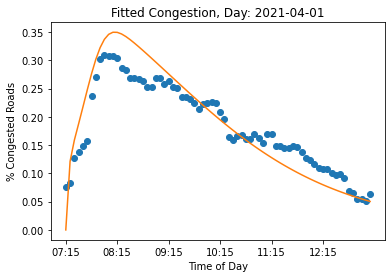

In [21]:
f_1, y_1, x_1, d_1, d_t_1, popt_1, mse, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df, df_d, '07:15', '13:15', plot = True)


In [22]:
df_mae_test = pd.DataFrame.from_dict(mae_test, orient='index').rename(columns = {0: 'MAE'})
df_mae_train = pd.DataFrame.from_dict(mae_train, orient='index').rename(columns = {0: 'MAE'})

df_mae = pd.concat([df_mae_train, df_mae_test])

df_mse_test = pd.DataFrame.from_dict(mse_test, orient='index').rename(columns = {0: 'MSE'})
df_mse_train = pd.DataFrame.from_dict(mse_train, orient='index').rename(columns = {0: 'MSE'})

df_mse = pd.concat([df_mse_train, df_mse_test])

df_mape_test = pd.DataFrame.from_dict(mape_test, orient='index').rename(columns = {0: 'MAPE'})
df_mape_train = pd.DataFrame.from_dict(mape_train, orient='index').rename(columns = {0: 'MAPE'})

df_mape = pd.concat([df_mape_train, df_mape_test])

df_full = pd.concat([df_mse, df_mape, df_mae], axis = 1)

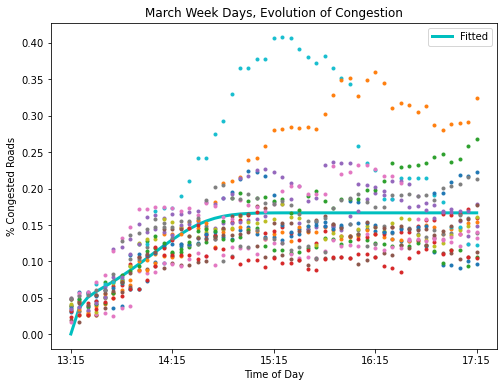

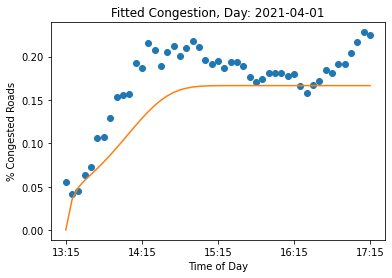

In [23]:
f_2, y_2, x_2, d_2, d_2_t, popt_2, mse, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df, df_d, '13:15', '17:20', plot = True)


In [24]:
df_mae_test = pd.DataFrame.from_dict(mae_test, orient='index').rename(columns = {0: 'MAE'})
df_mae_train = pd.DataFrame.from_dict(mae_train, orient='index').rename(columns = {0: 'MAE'})

df_mae = pd.concat([df_mae_train, df_mae_test])

df_mse_test = pd.DataFrame.from_dict(mse_test, orient='index').rename(columns = {0: 'MSE'})
df_mse_train = pd.DataFrame.from_dict(mse_train, orient='index').rename(columns = {0: 'MSE'})

df_mse = pd.concat([df_mse_train, df_mse_test])

df_mape_test = pd.DataFrame.from_dict(mape_test, orient='index').rename(columns = {0: 'MAPE'})
df_mape_train = pd.DataFrame.from_dict(mape_train, orient='index').rename(columns = {0: 'MAPE'})

df_mape = pd.concat([df_mape_train, df_mape_test])

df_full_2 = pd.concat([df_mse, df_mape, df_mae], axis = 1)

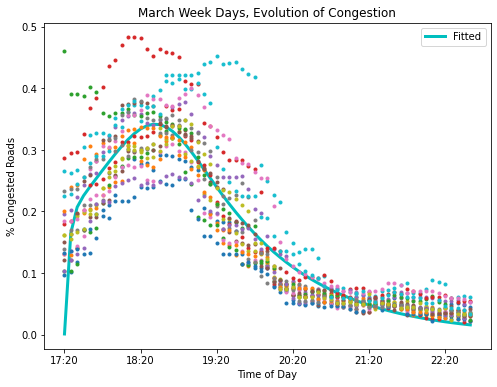

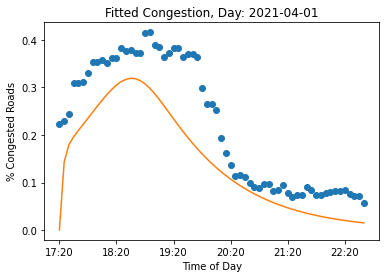

In [25]:
f_3, y_3, x_3, d_3, d_3_t, popt_3, mse, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df, df_d, '17:20', '22:45', plot = True)


In [26]:
df_mae_test = pd.DataFrame.from_dict(mae_test, orient='index').rename(columns = {0: 'MAE'})
df_mae_train = pd.DataFrame.from_dict(mae_train, orient='index').rename(columns = {0: 'MAE'})

df_mae = pd.concat([df_mae_train, df_mae_test])

df_mse_test = pd.DataFrame.from_dict(mse_test, orient='index').rename(columns = {0: 'MSE'})
df_mse_train = pd.DataFrame.from_dict(mse_train, orient='index').rename(columns = {0: 'MSE'})

df_mse = pd.concat([df_mse_train, df_mse_test])

df_mape_test = pd.DataFrame.from_dict(mape_test, orient='index').rename(columns = {0: 'MAPE'})
df_mape_train = pd.DataFrame.from_dict(mape_train, orient='index').rename(columns = {0: 'MAPE'})

df_mape = pd.concat([df_mape_train, df_mape_test])

df_full_3 = pd.concat([df_mse, df_mape, df_mae], axis = 1)

In [27]:
f_11 = f_1[len(d_1):]
x_11 = x_1[1:]
f_21 = f_2[len(d_2):]
x_21 = x_2[1:]
f_31 = f_3[len(d_3):]
x_31 = x_3[1:]

xdata_plot = x_11 + x_21 + x_31

# Results for other models on training set

In [29]:
f_12 = [0.11566264, 0.1938206 , 0.2457471 , 0.27935507, 0.30019488,
       0.31215749, 0.31796893, 0.31953817, 0.3182012 , 0.31489237,
       0.31026454, 0.30477344, 0.29873655, 0.29237472, 0.28584097,
       0.27924101, 0.27264729, 0.26610917, 0.25965971, 0.25332076,
       0.24710626, 0.24102466, 0.23508063, 0.22927622, 0.22361169,
       0.21808607, 0.21269754, 0.20744377, 0.20232208, 0.19732957,
       0.19246322, 0.18771996, 0.18309672, 0.17859042, 0.17419806,
       0.16991667, 0.16574335, 0.16167527, 0.15770965, 0.1538438 ,
       0.15007511, 0.14640103, 0.14281907, 0.13932683, 0.13592195,
       0.13260216, 0.12936525, 0.12620905, 0.12313149, 0.12013051,
       0.11720414, 0.11435045, 0.11156757, 0.10885369, 0.10620702,
       0.10362584, 0.10110849, 0.09865333, 0.09625877, 0.09392328,
       0.09164534, 0.0894235 , 0.08725633, 0.08514246, 0.08308053,
       0.08106924, 0.07910729, 0.07719347, 0.07532654, 0.07350534,
       0.07172871]

f_22 = [0.01743344, 0.03308953, 0.04749476, 0.06072714, 0.07286093,
       0.08396671, 0.09411147, 0.10335873, 0.11176866, 0.11939812,
       0.12630085, 0.13252754, 0.13812595, 0.14314104, 0.14761508,
       0.15158778, 0.15509638, 0.1581758 , 0.16085874, 0.16317578,
       0.16515551, 0.16682462, 0.16820804, 0.16932897, 0.17020905,
       0.17086841, 0.17132578, 0.17159855, 0.17170288, 0.17165377,
       0.17146511, 0.17114978, 0.17071971, 0.17018592, 0.16955862,
       0.16884722, 0.16806041, 0.16720622, 0.16629202, 0.16532463,
       0.16431033, 0.16325486, 0.16216348, 0.16104106, 0.15989204,
       0.1587205 , 0.15753016, 0.15632442]

f_32 = [0.13213606, 0.2216233 , 0.28028192, 0.31665115, 0.33719187,
       0.34667897, 0.3485807 , 0.34538292, 0.33884794, 0.33021301,
       0.32033836, 0.30981568, 0.29904662, 0.28829914, 0.27774778,
       0.26750213, 0.25762702, 0.24815673, 0.2391049 , 0.23047158,
       0.22224802, 0.21442007, 0.20697037, 0.19988   , 0.19312946,
       0.18669937, 0.1805709 , 0.17472603, 0.16914769, 0.16381979,
       0.15872732, 0.15385622, 0.14919346, 0.14472687, 0.14044517,
       0.13633788, 0.13239527, 0.12860826, 0.12496845, 0.12146799,
       0.11809959, 0.11485642, 0.11173214, 0.1087208 , 0.10581686,
       0.10301512, 0.1003107 , 0.09769903, 0.09517582, 0.09273704,
       0.09037891, 0.08809784, 0.08589046, 0.08375362, 0.0816843 ,
       0.07967969, 0.07773709, 0.07585398, 0.07402797, 0.07225676,
       0.07053822, 0.06887028, 0.06725102, 0.06567858]

f_13 = [0.10797682, 0.12299969, 0.13925391, 0.15659666, 0.17481581,
       0.19362967, 0.21269337, 0.23161226, 0.24996183, 0.26731244,
       0.28325603, 0.2974316 , 0.30954627, 0.31938966, 0.32684023,
       0.33186407, 0.33450706, 0.33488244, 0.33315583, 0.32952966,
       0.32422851, 0.31748626, 0.30953569, 0.30060053, 0.29088996,
       0.280595  , 0.26988674, 0.25891573, 0.24781234, 0.23668779,
       0.22563556, 0.214733  , 0.20404305, 0.19361594, 0.18349084,
       0.17369736, 0.16425693, 0.15518407, 0.14648749, 0.13817108,
       0.13023473, 0.12267508, 0.11548617, 0.10865994, 0.10218675,
       0.0960557 , 0.09025501, 0.08477225, 0.07959462, 0.07470909,
       0.07010256, 0.06576202, 0.06167461, 0.05782772, 0.05420906,
       0.05080669, 0.04760905, 0.04460502, 0.0417839 , 0.03913545,
       0.03664987, 0.03431781, 0.03213036, 0.03007906, 0.02815585,
       0.02635313, 0.02466367, 0.02308064, 0.02159757, 0.02020837,
       0.01890728]

f_23 = [0.03408144, 0.03780507, 0.04186902, 0.04628908, 0.05107813,
       0.05624525, 0.06179462, 0.06772446, 0.07402588, 0.08068187,
       0.08766627, 0.09494306, 0.10246581, 0.11017761, 0.11801137,
       0.12589065, 0.13373102, 0.14144191, 0.14892896, 0.15609672,
       0.16285157, 0.16910465, 0.17477475, 0.17979085, 0.18409422,
       0.18763995, 0.19039789, 0.19235287, 0.19350441, 0.19386575,
       0.19346257, 0.19233132, 0.19051734, 0.18807292, 0.18505537,
       0.18152518, 0.17754436, 0.17317497, 0.16847786, 0.16351164,
       0.15833196, 0.15299082, 0.14753627, 0.14201214, 0.13645793,
       0.13090884, 0.12539588, 0.11994605]

f_33 = [0.11745468, 0.13901394, 0.16269759, 0.18804966, 0.21439813,
       0.24088281, 0.26651999, 0.29029695, 0.31127902, 0.32870718,
       0.34206623, 0.35111264, 0.35586274, 0.35655062, 0.35356979,
       0.34741175, 0.33861102, 0.3277018 , 0.31518751, 0.30152216,
       0.28710117, 0.27225909, 0.25727182, 0.24236148, 0.22770266,
       0.21342899, 0.19963955, 0.18640479, 0.17377177, 0.16176873,
       0.15040896, 0.13969403, 0.12961648, 0.12016205, 0.11131143,
       0.10304171, 0.09532758, 0.08814218, 0.08145788, 0.07524681,
       0.06948128, 0.06413416, 0.05917904, 0.05459048, 0.05034411,
       0.04641666, 0.04278607, 0.03943147, 0.0363332 , 0.03347275,
       0.03083279, 0.02839708, 0.02615045, 0.02407877, 0.02216886,
       0.02040847, 0.01878619, 0.01729147, 0.01591449, 0.01464617,
       0.01347809, 0.01240246, 0.01141207, 0.01050027]

In [30]:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

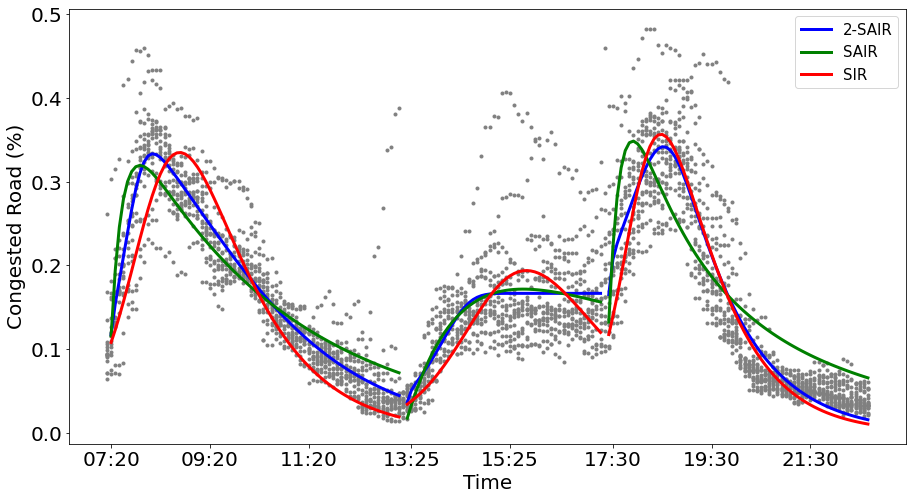

In [31]:
figure, axis = plt.subplots(figsize = (15, 8))

colors = sns.color_palette("hls", 31)
axis.set_prop_cycle('color', colors)


for d in range(len(d_1)):
    axis.plot(x_1, y_1[d], 'o', markersize = 3, color = '0.5')
axis.plot(x_11, f_11[::len(d_1)], linewidth = 3, label = "2-SAIR", color = 'b')
axis.plot(x_11, f_12, linewidth = 3, label = "SAIR", color = 'g')
axis.plot(x_11, f_13, linewidth = 3, label = "SIR", color = 'r')

for d in range(len(d_2)):
    axis.plot(x_2, y_2[d], 'o', markersize = 3, color = '0.5')            
axis.plot(x_21, f_21[::len(d_2)], linewidth = 3, color = 'b')
axis.plot(x_21, f_22, linewidth = 3, color = 'g')
axis.plot(x_21, f_23, linewidth = 3, color = 'r')

for d in range(len(d_3)):
    axis.plot(x_3, y_3[d], 'o', markersize = 3, color = '0.5')
axis.plot(x_31, f_31[::len(d_3)], linewidth = 3, color = 'b')
axis.plot(x_31, f_32, linewidth = 3, color = 'g')
axis.plot(x_31, f_33, linewidth = 3, color = 'r')
    
axis.set_xlabel('Time')
axis.set_ylabel('Congested Road (%)')
axis.legend(prop={'size': 15})
axis.set_xticks(xdata_plot[::24])
figure.savefig("in_sample.png")

# Results on testing set

In [32]:
#df_prep_1 = data_preparation(df, '07:10', '13:15')
#df_predict_1 = remove_outliers(df_prep_1)

df_prep_test_1 = data_preparation(df_d, '07:15', '13:15')
df_prep_test_1 = remove_outliers(df_prep_test_1)

#df_prep_2 = data_preparation(df, '13:15', '17:20')
#df_predict_2 = remove_outliers(df_prep_2)

df_prep_test_2 = data_preparation(df_d, '13:15', '17:20')
df_prep_test_2 = remove_outliers(df_prep_test_2)

#df_prep_3 = data_preparation(df, '17:20', '22:45')
#df_predict_3 = remove_outliers(df_prep_3)

df_prep_test_3 = data_preparation(df_d, '17:20', '22:45')
df_prep_test_3 = remove_outliers(df_prep_test_3)

In [33]:
N = 1.0

I0 = df_prep_test_1[df_prep_test_1['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% C'][0]
S0 = df_prep_test_1[df_prep_test_1['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% F_F'][0]
AS0 = df_prep_test_1[df_prep_test_1['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% I_F'][0]
W0 = df_prep_test_1[df_prep_test_1['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% F_W'][0]
AW0 = df_prep_test_1[df_prep_test_1['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% I_W'][0]
R0 = 1 - I0 - S0 - AS0 - W0 - AW0
        
ydata_1 = df_prep_test_1[df_prep_test_1['Date'] == df_prep_test_1['Date'].unique()[4]]['% C']
ydata_1 = np.array(ydata_1, dtype=float)

xdata_time_1 = df_prep_test_1['Time'].unique()
xdata_test_1 = np.array([i+1 for i in range(len(xdata_time_1))])
xdata_plot_t_1 = [str(i)[:5] for i in xdata_time_1]
fitted_t_1 = fit_odeint_complex(xdata_test_1, *popt_1)

N = 1.0

I0 = df_prep_test_2[df_prep_test_2['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% C'][0]
S0 = df_prep_test_2[df_prep_test_2['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% F_F'][0]
AS0 = df_prep_test_2[df_prep_test_2['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% I_F'][0]
W0 = df_prep_test_2[df_prep_test_2['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% F_W'][0]
AW0 = df_prep_test_2[df_prep_test_2['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% I_W'][0]
R0 = 1 - I0 - S0 - AS0 - W0 - AW0
        
ydata_2 = df_prep_test_2[df_prep_test_2['Date'] == df_prep_test_1['Date'].unique()[3]]['% C']
ydata_2 = np.array(ydata_2, dtype=float)

xdata_time_2 = df_prep_test_2['Time'].unique()
xdata_test_2 = np.array([i+1 for i in range(len(xdata_time_2))])
xdata_plot_t_2 = [str(i)[:5] for i in xdata_time_2]
fitted_t_2 = fit_odeint_complex(xdata_test_2, *popt_2)

N = 1.0

I0 = df_prep_test_3[df_prep_test_3['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% C'][0]
S0 = df_prep_test_3[df_prep_test_3['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% F_F'][0]
AS0 = df_prep_test_3[df_prep_test_3['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% I_F'][0]
W0 = df_prep_test_3[df_prep_test_3['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% F_W'][0]
AW0 = df_prep_test_3[df_prep_test_3['Date'] == df_prep_test_1['Date'].unique()[3]].reset_index()['% I_W'][0]
R0 = 1 - I0 - S0 - AS0 - W0 - AW0
        
ydata_3 = df_prep_test_3[df_prep_test_3['Date'] == df_prep_test_1['Date'].unique()[3]]['% C']
ydata_3 = np.array(ydata_3, dtype=float)

xdata_time_3 = df_prep_test_3['Time'].unique()
xdata_test_3 = np.array([i+1 for i in range(len(xdata_time_3))])
xdata_plot_t_3 = [str(i)[:5] for i in xdata_time_3]
fitted_t_3 = fit_odeint_complex(xdata_test_3, *popt_3)

In [34]:
fitted_t_1 = fitted_t_1[1:]
fitted_t_2 = fitted_t_2[1:]
fitted_t_3 = fitted_t_3[1:]

In [35]:
xdata_plot_t_1 = xdata_plot_t_1[1:]
xdata_plot_t_2 = xdata_plot_t_2[1:]
xdata_plot_t_3 = xdata_plot_t_3[1:]

In [36]:
sir_1 = [0.12714547, 0.14405621, 0.16207812, 0.18097668, 0.20044362,
       0.22010499, 0.23953704, 0.25828878, 0.27590952, 0.2919777 ,
       0.30612759, 0.31807053, 0.32760836, 0.33463807, 0.33914832,
       0.34120935, 0.34095852, 0.33858377, 0.334307  , 0.32836881,
       0.32101558, 0.31248918, 0.30301945, 0.29281906, 0.28208051,
       0.27097473, 0.25965093, 0.24823733, 0.23684244, 0.22555671,
       0.21445433, 0.20359508, 0.1930261 , 0.18278361, 0.17289444,
       0.16337748, 0.15424489, 0.14550324, 0.13715449, 0.1291968 ,
       0.12162526, 0.11443252, 0.10760933, 0.10114493, 0.09502751,
       0.08924443, 0.08378255, 0.07862843, 0.07376848, 0.06918914,
       0.06487698, 0.06081877, 0.05700162, 0.05341297, 0.05004064,
       0.04687291, 0.0438985 , 0.04110658, 0.03848679, 0.03602926,
       0.03372455, 0.03156371, 0.02953824, 0.02764005, 0.02586151,
       0.02419539, 0.02263483, 0.0211734 , 0.01980498, 0.01852383,
       0.01732455]

sir_2 = [0.03555229, 0.03942214, 0.04364106, 0.048224  , 0.05318262,
       0.05852428, 0.06425106, 0.07035851, 0.07683459, 0.08365862,
       0.09080038, 0.09821941, 0.10586464, 0.1136745 , 0.12157735,
       0.12949264, 0.13733239, 0.14500339, 0.15240962, 0.15945517,
       0.16604724, 0.17209904, 0.17753266, 0.18228141, 0.18629176,
       0.18952464, 0.19195606, 0.19357712, 0.1943934 , 0.19442384,
       0.19369925, 0.1922605 , 0.19015663, 0.18744281, 0.18417846,
       0.18042544, 0.17624646, 0.17170371, 0.16685762, 0.16176606,
       0.15648352, 0.15106069, 0.14554409, 0.13997593, 0.13439405,
       0.12883199, 0.12331914, 0.1178809 ]

sir_3 = [0.1872793 , 0.21599716, 0.2452854 , 0.27401714, 0.30098773,
       0.32505016, 0.34524616, 0.36090364, 0.37168227, 0.37756505,
       0.37880779, 0.37586561, 0.36931451, 0.35978167, 0.34789122,
       0.33422709, 0.31931118, 0.30359339, 0.28745017, 0.27118827,
       0.25505153, 0.23922892, 0.22386278, 0.20905663, 0.19488221,
       0.18138565, 0.16859273, 0.15651325, 0.14514469, 0.1344752 ,
       0.12448595, 0.11515315, 0.10644952, 0.09834555, 0.09081045,
       0.08381289, 0.07732157, 0.07130564, 0.06573505, 0.06058074,
       0.05581485, 0.05141078, 0.04734326, 0.04358843, 0.04012375,
       0.03692809, 0.0339816 , 0.03126574, 0.02876319, 0.0264578 ,
       0.02433455, 0.02237949, 0.02057964, 0.01892297, 0.01739836,
       0.01599549, 0.0147048 , 0.01351749, 0.01242538, 0.01142096,
       0.01049727, 0.00964789, 0.00886691, 0.00814887]

shir_1 = [0.11478164, 0.19113095, 0.24184407, 0.27465498, 0.29498838,
       0.30664682, 0.31229455, 0.31379711, 0.31246006, 0.3091965 ,
       0.30464448, 0.29924924, 0.29332115, 0.28707591, 0.28066315,
       0.27418607, 0.26771557, 0.26129981, 0.25497115, 0.24875091,
       0.2426527 , 0.23668481, 0.23085177, 0.2251556 , 0.21959657,
       0.21417368, 0.20888517, 0.20372877, 0.19870186, 0.19380159,
       0.18902503, 0.18436915, 0.17983094, 0.17540741, 0.17109561,
       0.16689263, 0.16279564, 0.15880186, 0.15490858, 0.15111316,
       0.14741305, 0.14380574, 0.1402888 , 0.13685987, 0.13351666,
       0.13025693, 0.12707851, 0.12397929, 0.12095722, 0.11801031,
       0.1151366 , 0.11233423, 0.10960134, 0.10693616, 0.10433695,
       0.10180202, 0.09932973, 0.09691848, 0.09456672, 0.09227293,
       0.09003564, 0.08785341, 0.08572486, 0.08364862, 0.08162338,
       0.07964784, 0.07772076, 0.07584092, 0.07400712, 0.07221822,
       0.07047308]

shir_2 = [0.01699994, 0.03266692, 0.04708282, 0.06032565, 0.07246969,
       0.0835855 , 0.09374009, 0.10299698, 0.11141634, 0.11905504,
       0.1259668 , 0.13220233, 0.13780938, 0.14283292, 0.14731521,
       0.15129597, 0.15481243, 0.15789952, 0.16058993, 0.16291425,
       0.16490107, 0.16657709, 0.16796722, 0.16909469, 0.16998112,
       0.17064666, 0.17111003, 0.17138862, 0.17149861, 0.17145499,
       0.17127166, 0.1709615 , 0.17053644, 0.17000751, 0.16938492,
       0.16867808, 0.1678957 , 0.16704579, 0.16613576, 0.1651724 ,
       0.16416198, 0.16311027, 0.16202254, 0.16090366, 0.15975806,
       0.15858984, 0.1574027 , 0.15620007]

shir_3 = [0.12237134, 0.20596373, 0.26097677, 0.29532774, 0.31498685,
       0.32436079, 0.32665046, 0.32415258, 0.31849865, 0.31083713,
       0.30196927, 0.29244869, 0.28265313, 0.27283653, 0.26316588,
       0.25374753, 0.24464591, 0.23589658, 0.22751557, 0.21950584,
       0.2118618 , 0.2045725 , 0.19762376, 0.19099964, 0.18468347,
       0.17865849, 0.17290828, 0.167417  , 0.1621696 , 0.15715185,
       0.15235037, 0.14775264, 0.14334697, 0.13912247, 0.13506899,
       0.13117707, 0.12743792, 0.12384332, 0.12038565, 0.11705777,
       0.11385304, 0.11076525, 0.10778859, 0.10491763, 0.10214727,
       0.09947276, 0.0968896 , 0.0943936 , 0.0919808 , 0.08964747,
       0.08739013, 0.08520546, 0.08309034, 0.08104184, 0.07905717,
       0.07713371, 0.07526896, 0.07346056, 0.07170628, 0.070004  ,
       0.0683517 , 0.06674748, 0.06518951, 0.06367607]

In [37]:
len(fitted_t_1)

71

In [38]:
len(xdata_plot_t_1)

71

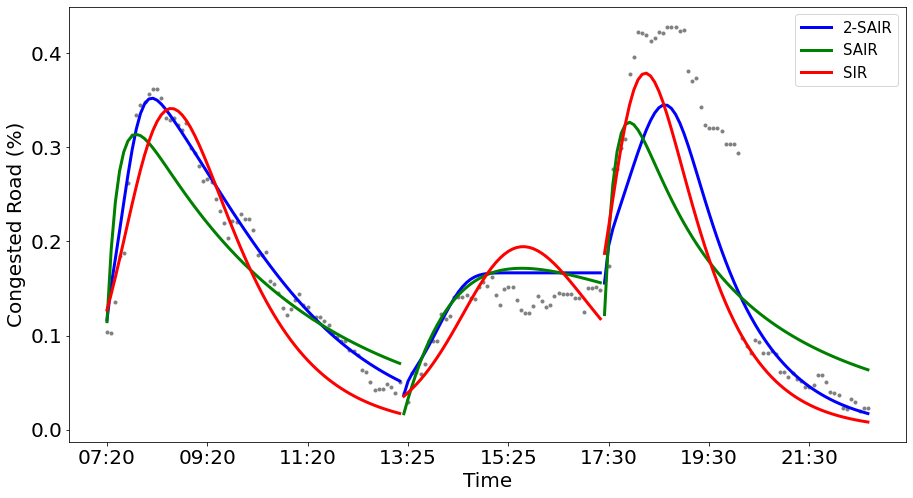

In [39]:
figure, axis = plt.subplots(figsize = (15, 8))

colors = sns.color_palette("hls", 31)
axis.set_prop_cycle('color', colors)

axis.plot(xdata_plot_t_1, ydata_1[1:], 'o', color = '0.5', markersize = 3)
axis.plot(xdata_plot_t_1, fitted_t_1, linewidth = 3, label = "2-SAIR", color = 'b')
axis.plot(xdata_plot_t_1, shir_1, linewidth = 3, label = "SAIR", color = 'g')
axis.plot(xdata_plot_t_1, sir_1, linewidth = 3, label = "SIR", color = 'r')

axis.plot(xdata_plot_t_2, ydata_2[1:], 'o', color = '0.5', markersize = 3)
axis.plot(xdata_plot_t_2, fitted_t_2, linewidth = 3, color = 'b')
axis.plot(xdata_plot_t_2, shir_2, linewidth = 3, color = 'g')
axis.plot(xdata_plot_t_2, sir_2, linewidth = 3, color = 'r')

axis.plot(xdata_plot_t_3, ydata_3[1:], 'o', color = '0.5', markersize = 3)
axis.plot(xdata_plot_t_3, fitted_t_3, linewidth = 3, color = 'b')
axis.plot(xdata_plot_t_3, shir_3, linewidth = 3, color = 'g')
axis.plot(xdata_plot_t_3, sir_3, linewidth = 3, color = 'r')

axis.set_xlabel('Time')
axis.set_ylabel('Congested Road (%)')
axis.legend(prop={'size': 15})
axis.set_xticks(xdata_plot[::24])
figure.savefig("out_sample.png")

# Fit for each region

In [86]:
df_west = df[df['Region'] == 'west']
df_central = df[df['Region'] == 'central']
df_northeast = df[df['Region'] == 'northeast']
df_east = df[df['Region'] == 'east']
df_north = df[df['Region'] == 'north']

In [87]:
df_d_west = df_d[df_d['Region'] == 'west']
df_d_central = df_d[df_d['Region'] == 'central']
df_d_northeast = df_d[df_d['Region'] == 'northeast']
df_d_east = df_d[df_d['Region'] == 'east']
df_d_north = df_d[df_d['Region'] == 'north']

# West

S:  0.8470149253731343
AS: 0.0
W: 0.08395522388059702
AW: 0.0
C: 0.06902985074626866
R: 4.163336342344337e-17


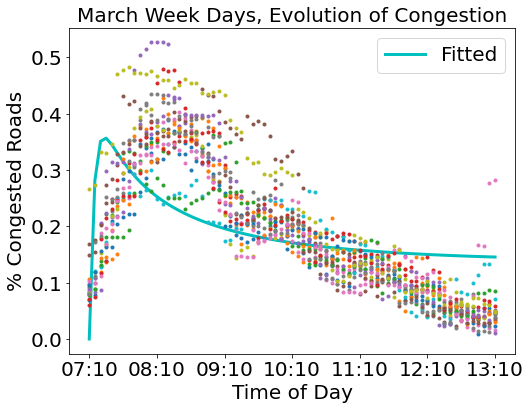

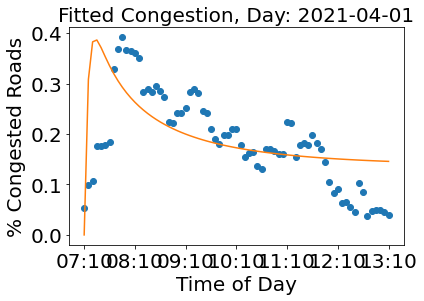

In [89]:
f_1, y_1, x_1, d_1, d_t_1, popt_west_1, mse_west, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_west, df_d_west, '07:10', '13:15', plot = True, initial = True)


S:  0.8619402985074627
AS: 0.0
W: 0.08582089552238806
AW: 0.0
C: 0.05223880597014925
R: -2.7755575615628914e-17


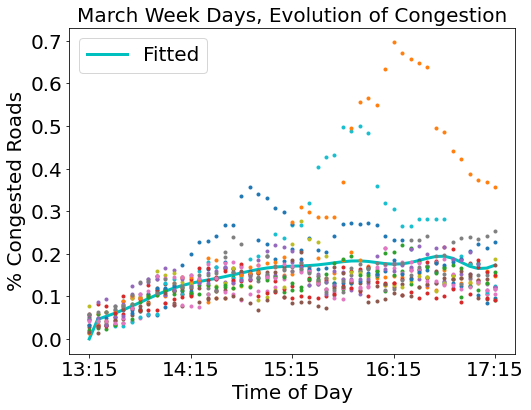

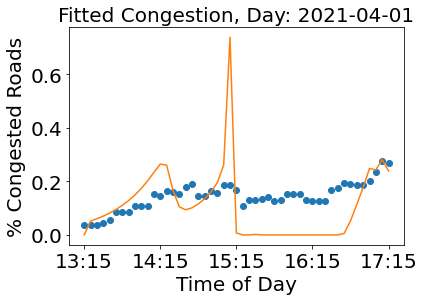

In [90]:
f_1, y_1, x_1, d_1, d_t_1, popt_west_2, mse_west, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_west, df_d_west, '13:15', '17:20', plot = True, initial = True)


S:  0.8208955223880597
AS: 0.0
W: 0.08022388059701492
AW: 0.0
C: 0.09888059701492537
R: -1.3877787807814457e-17


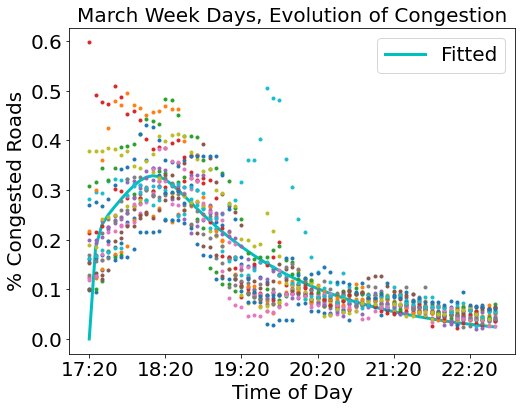

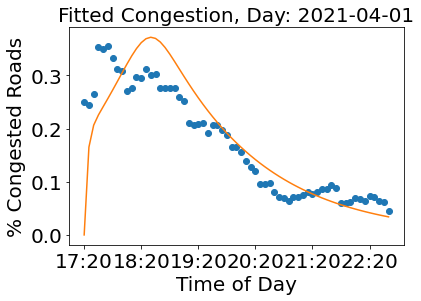

In [91]:
f_1, y_1, x_1, d_1, d_t_1, popt_west_3, mse_west, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_west, df_d_west, '17:20', '22:45', plot = True, initial = True)


# Central

S:  0.9224904701397713
AS: 0.0
W: 0.04955527318932656
AW: 0.0
C: 0.02795425667090216
R: 6.245004513516506e-17


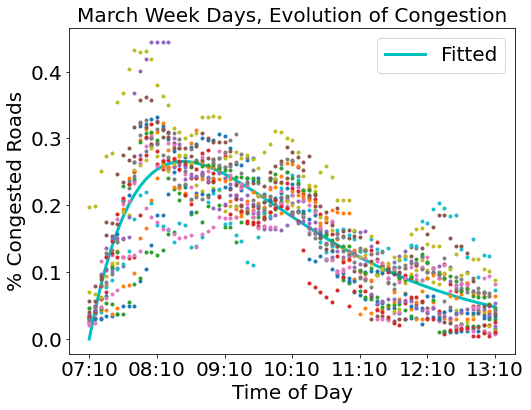

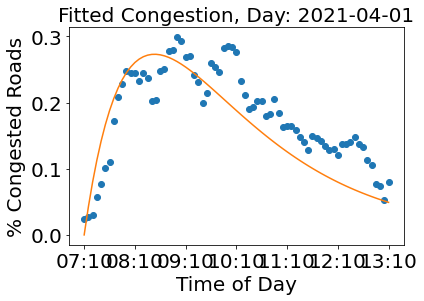

In [92]:
f_1, y_1, x_1, d_1, d_t_1, popt_central_1, mse_central, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_central, df_d_central, '07:10', '13:15', plot = True, initial = True)


S:  0.9301143583227446
AS: 0.0012706480304955528
W: 0.04701397712833545
AW: 0.0
C: 0.021601016518424398
R: 2.7755575615628914e-17


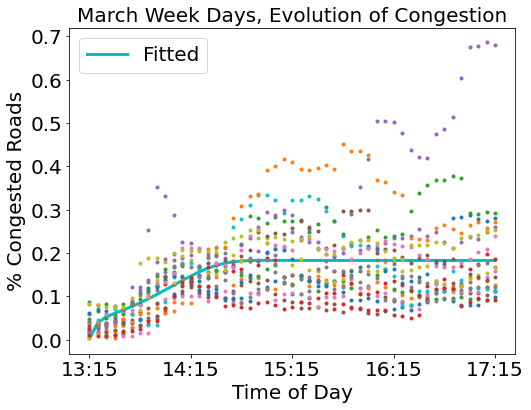

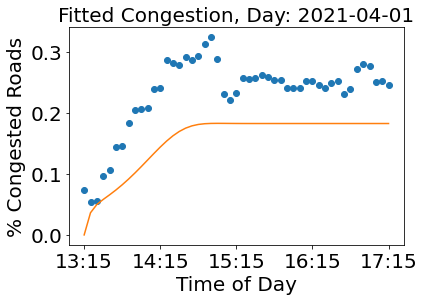

In [93]:
f_1, y_1, x_1, d_1, d_t_1, popt_central_2, mse_central, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_central, df_d_central, '13:15', '17:20', plot = True, initial = True)


S:  0.8526048284625158
AS: 0.0025412960609911056
W: 0.04701397712833545
AW: 0.0
C: 0.09783989834815757
R: 6.245004513516506e-17


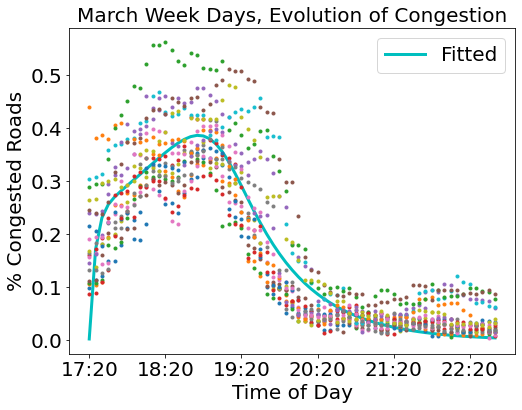

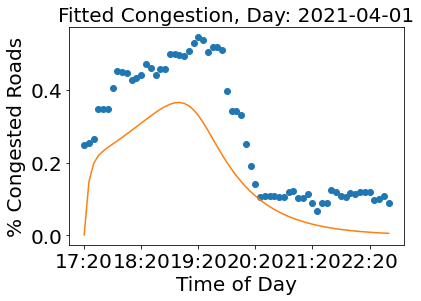

In [94]:
f_1, y_1, x_1, d_1, d_t_1, popt_central_3, mse_central, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_central, df_d_central, '17:20', '22:45', plot = True, initial = True)


# Northeast

S:  0.7666666666666667
AS: 0.0
W: 0.014285714285714285
AW: 0.0
C: 0.21904761904761905
R: -5.0306980803327406e-17


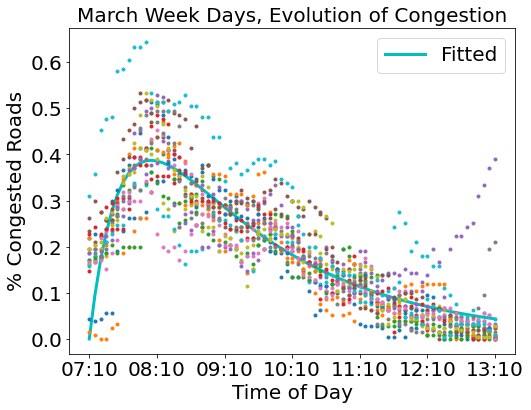

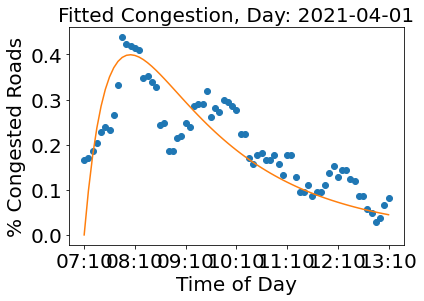

In [95]:
f_1, y_1, x_1, d_1, d_t_1, popt_northeast_1, mse_northeast, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_northeast, df_d_northeast, '07:10', '13:15', plot = True, initial = True)


S:  0.9619047619047619
AS: 0.0
W: 0.02857142857142857
AW: 0.0
C: 0.009523809523809525
R: 1.0408340855860843e-17


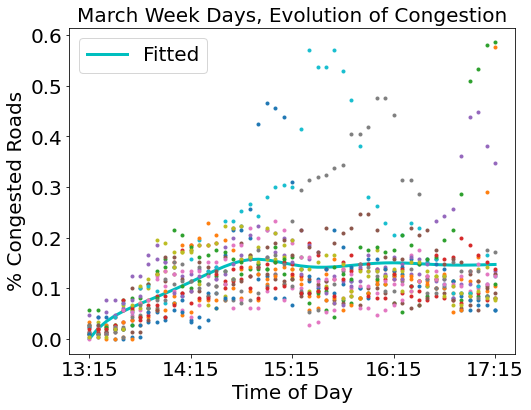

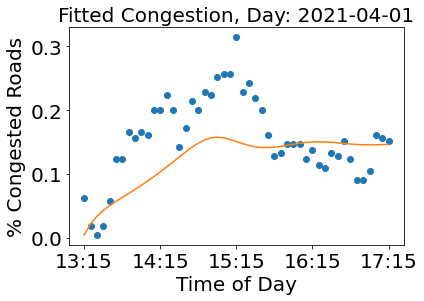

In [96]:
f_1, y_1, x_1, d_1, d_t_1, popt_northeast_2, mse_northeast, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_northeast, df_d_northeast, '13:15', '17:20', plot = True, initial = True)


S:  0.9142857142857143
AS: 0.0
W: 0.02857142857142857
AW: 0.0
C: 0.05714285714285714
R: 1.0408340855860843e-17


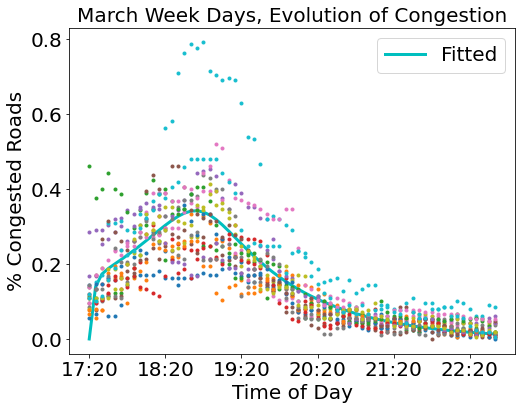

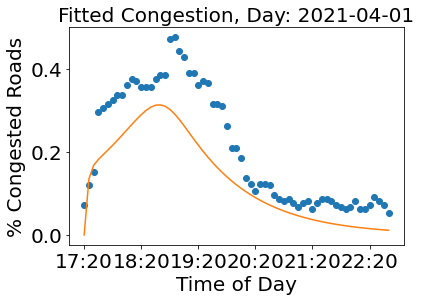

In [97]:
f_1, y_1, x_1, d_1, d_t_1, popt_northeast_3, mse_northeast, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_northeast, df_d_northeast, '17:20', '22:45', plot = True, initial = True)


# East

S:  0.8341836734693877
AS: 0.0
W: 0.07142857142857142
AW: 0.0
C: 0.09438775510204081
R: 8.326672684688674e-17


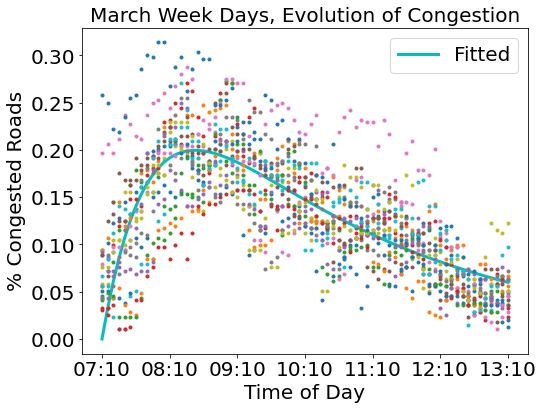

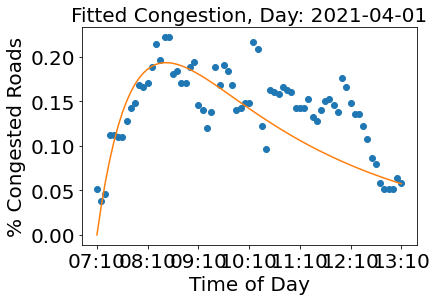

In [98]:
f_1, y_1, x_1, d_1, d_t_1, popt_east_1, mse_east, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_east, df_d_east, '07:10', '13:15', plot = True, initial = True)


S:  0.8801020408163265
AS: 0.0
W: 0.06887755102040816
AW: 0.0
C: 0.05102040816326531
R: 1.1102230246251565e-16


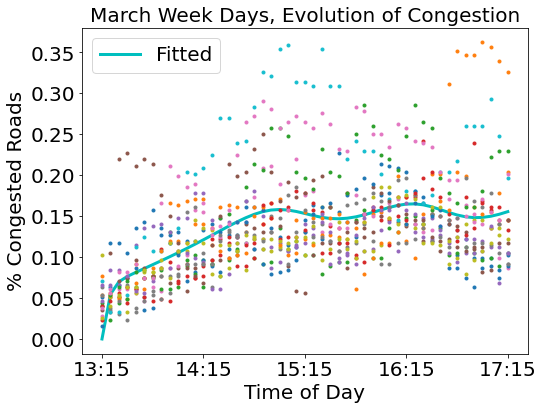

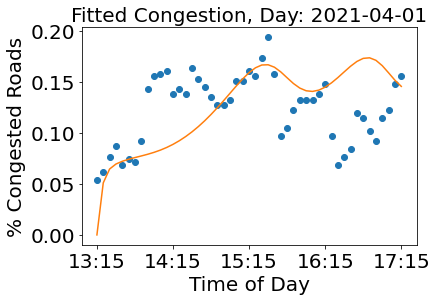

In [99]:
f_1, y_1, x_1, d_1, d_t_1, popt_east_2, mse_east, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_east, df_d_east, '13:15', '17:20', plot = True, initial = True)


S:  0.8341836734693877
AS: 0.0
W: 0.06377551020408163
AW: 0.0
C: 0.10204081632653061
R: 4.163336342344337e-17


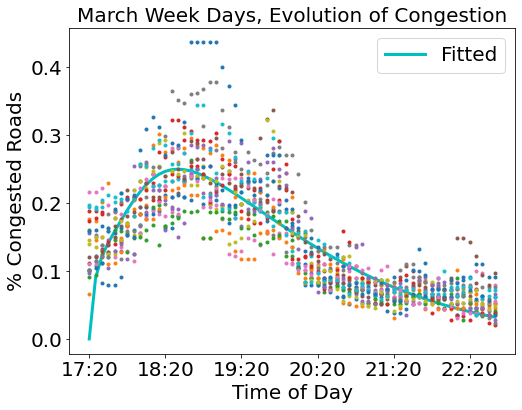

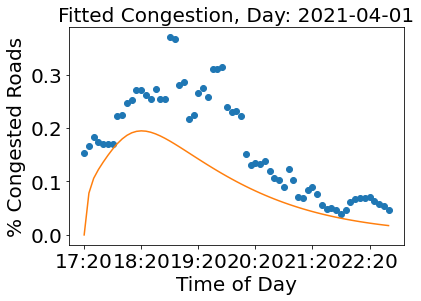

In [100]:
f_1, y_1, x_1, d_1, d_t_1, popt_east_3, mse_east, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_east, df_d_east, '17:20', '22:45', plot = True, initial = True)


# North

S:  0.8521739130434782
AS: 0.0
W: 0.004347826086956522
AW: 0.0
C: 0.14347826086956522
R: -2.5153490401663703e-17


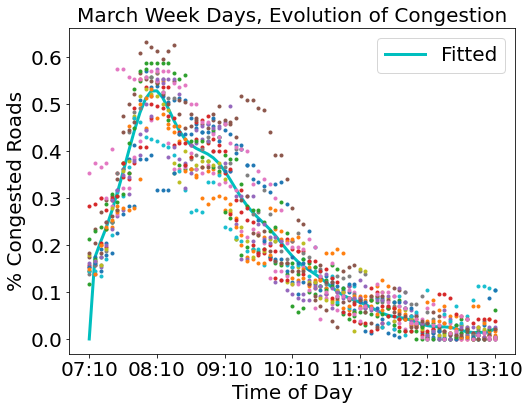

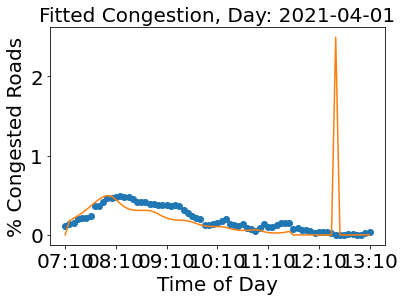

In [101]:
f_1, y_1, x_1, d_1, d_t_1, popt_north_1, mse_north, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_north, df_d_north, '07:10', '13:15', plot = True, initial = True)


S:  0.9956521739130435
AS: 0.0
W: 0.004347826086956522
AW: 0.0
C: 0.0
R: -2.5153490401663703e-17


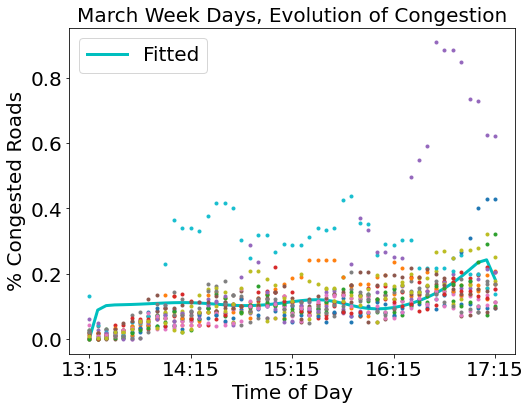

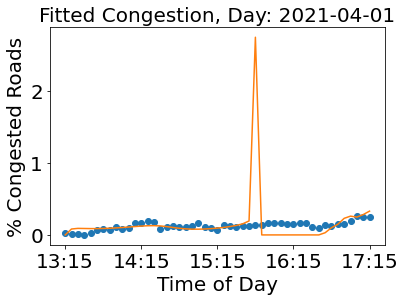

In [107]:
f_1, y_1, x_1, d_1, d_t_1, popt_north_2, mse_north, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_north, df_d_north, '13:15', '17:20', plot = True, initial = True)


S:  0.9
AS: 0.0
W: 0.004347826086956522
AW: 0.0
C: 0.09565217391304348
R: -2.5153490401663703e-17


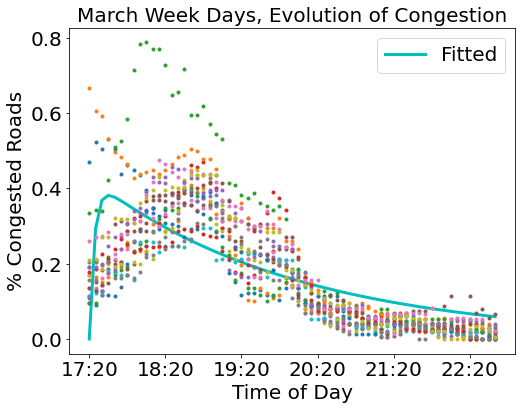

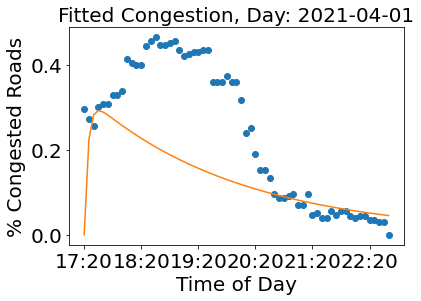

In [103]:
f_1, y_1, x_1, d_1, d_t_1, popt_north_3, mse_north, mape_, mae, mse_train, mape_train, mae_train, mse_test, mape_test, mae_test = train_test_model(df_north, df_d_north, '17:20', '22:45', plot = True, initial = True)


# Get parameters of the model

In [2]:
pop_west = [0.06419153, 0.09895452, 0.30535529, 0.06402125, 3.03482784,
       0.3390907 , 0.11174419, 2.22349804, 1.76991308]
pop_central = [1.00721586e-11, 4.54091969e-02, 9.54325731e-09, 7.39412598e-02,
       1.25360258e+00, 8.63433677e-01, 5.68242018e-01, 1.35599682e+00,
       1.98158799e+00]
pop_northeast = [0.08076916, 0.12946079, 0.18327505, 0.05240071, 3.08286569,
       2.00349858, 0.28901456, 2.87341499, 3.76956596]
pop_east = [0.04468193, 0.04108849, 0.34986072, 0.08786406, 1.1399531 ,
       2.05378525, 0.38426705, 1.82266323, 2.24996136]
pop_north = [0.50760347, 0.47150291, 1.5515801 , 1.6133897 , 1.39337254,
       0.99274866, 2.0449483 , 2.00435708, 1.06053377]

In [108]:
index = ["West", "Central", "Northeast", "East", "North"]
name = ["alpha_f", "beta_f", "rho_f", "mu_f", "alpha_w", "beta_w", "rho_w", "mu_w", "theta"]

In [134]:
df_param_w_1 = pd.DataFrame(popt_west_1, index = name)
df_param_c_1 = pd.DataFrame(popt_central_1, index = name)
df_param_ne_1 = pd.DataFrame(popt_northeast_1, index = name)
df_param_e_1 = pd.DataFrame(popt_east_1, index = name)
df_param_n_1 = pd.DataFrame(popt_north_1, index = name)
df_param_1 = pd.concat([df_param_w_1.T, df_param_c_1.T, df_param_ne_1.T, df_param_e_1.T, df_param_n_1.T]).reset_index()
df_p_1 = df_param_1.rename(index = {0:"West", 1:"Central", 2:"Northeast", 3:"East", 4:"North"})[name]

df_param_w_2 = pd.DataFrame(popt_west_2, index = name)
df_param_c_2 = pd.DataFrame(popt_central_2, index = name)
df_param_ne_2 = pd.DataFrame(popt_northeast_2, index = name)
df_param_e_2 = pd.DataFrame(popt_east_2, index = name)
df_param_n_2 = pd.DataFrame(popt_north_2, index = name)
df_param_2 = pd.concat([df_param_w_2.T, df_param_c_2.T, df_param_ne_2.T, df_param_e_2.T, df_param_n_2.T]).reset_index()
df_p_2 = df_param_2.rename(index = {0:"West", 1:"Central", 2:"Northeast", 3:"East", 4:"North"})[name]

df_param_w_3 = pd.DataFrame(popt_west_3, index = name)
df_param_c_3 = pd.DataFrame(popt_central_3, index = name)
df_param_ne_3 = pd.DataFrame(popt_northeast_3, index = name)
df_param_e_3 = pd.DataFrame(popt_east_3, index = name)
df_param_n_3 = pd.DataFrame(popt_north_3, index = name)
df_param_3 = pd.concat([df_param_w_3.T, df_param_c_3.T, df_param_ne_3.T, df_param_e_3.T, df_param_n_3.T]).reset_index()
df_p_3 = df_param_3.rename(index = {0:"West", 1:"Central", 2:"Northeast", 3:"East", 4:"North"})[name]

df_full = pd.concat([df_p_1, df_p_2, df_p_3])


In [135]:
df_full['alpha_f'] = df_full['alpha_f'].apply(lambda x: round(x,3))
df_full['beta_f'] = df_full['beta_f'].apply(lambda x: round(x,3))
df_full['rho_f'] = df_full['rho_f'].apply(lambda x: round(x,3))
df_full['mu_f'] = df_full['mu_f'].apply(lambda x: round(x,3))

df_full['alpha_w'] = df_full['alpha_w'].apply(lambda x: round(x,3))
df_full['beta_w'] = df_full['beta_w'].apply(lambda x: round(x,3))
df_full['rho_w'] = df_full['rho_w'].apply(lambda x: round(x,3))
df_full['mu_w'] = df_full['mu_w'].apply(lambda x: round(x,3))

df_full['theta'] = df_full['theta'].apply(lambda x: round(x,3))

In [137]:
df_full

,alpha_f,beta_f,rho_f,mu_f,alpha_w,beta_w,rho_w,mu_w,theta
West,0.531,0.578,1.126,0.569,3.966,1.585,0.411,4.835,10.354
Central,0.000,0.048,0.034,0.076,1.224,0.875,1.180,1.544,2.135
Northeast,0.000,0.137,0.345,0.078,1.240,0.198,1.023,2.273,4.742
East,0.052,0.041,0.432,0.086,2.745,3.086,1.201,1.934,3.950
North,0.492,0.562,1.450,2.043,1.396,0.896,2.162,1.878,1.113
West,0.897,0.180,1.913,3.180,2.852,1.321,1.208,3.444,2.512
Central,0.862,0.070,3.259,1.144,1.098,1.026,0.338,1.831,3.477
Northeast,0.782,0.024,5.786,0.283,1.215,2.360,0.002,3.555,1.381
East,0.838,0.115,2.143,1.260,0.000,0.288,0.000,0.137,1.283
North,1.538,0.196,1.856,1.656,0.987,1.085,0.996,0.930,1.111


In [18]:
df_param.rename(index = {0:"West", 1:"Central", 2:"Northeast", 3:"East", 4:"North"})[name]

,alpha_f,beta_f,rho_f,mu_f,alpha_w,beta_w,rho_w,mu_w,theta
West,6.419153e-02,0.098955,3.053553e-01,0.064021,3.034828,0.339091,0.111744,2.223498,1.769913
Central,1.007216e-11,0.045409,9.543257e-09,0.073941,1.253603,0.863434,0.568242,1.355997,1.981588
Northeast,8.076916e-02,0.129461,1.832750e-01,0.052401,3.082866,2.003499,0.289015,2.873415,3.769566
East,4.468193e-02,0.041088,3.498607e-01,0.087864,1.139953,2.053785,0.384267,1.822663,2.249961
North,5.076035e-01,0.471503,1.551580e+00,1.613390,1.393373,0.992749,2.044948,2.004357,1.060534
